# Energy estimation comparison

In [3]:
import sys


sys.path.append("..")
from pathlib import Path
from argparse import ArgumentParser
import torch as th
from src.diffusion.base import DiffusionSampler, _sample_x_t_given_x_0
from src.diffusion.beta_schedules import (
    improved_beta_schedule,
    linear_beta_schedule,
    respaced_beta_schedule,
)
from src.utils.net import get_device, Device
# from src.model.guided_diff.unet import load_guided_diff_unet
from src.model.guided_diff.classifier import load_guided_classifier
from src.model.resnet import load_classifier_t
from src.model.unet import load_mnist_diff
from src.guidance.base import GuidanceSampler, MCMCGuidanceSampler
from src.guidance.classifier_full import ClassifierFullGuidance
from src.samplers.mcmc import AnnealedHMCScoreSampler, estimate_energy_diff_linear
from exp.utils import SimulationConfig, setup_results_dir, get_step_size
from src.utils.seeding import set_seed
from src.data.mnist import get_mnist_data_loaders
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

# MNIST

Load pre-trained diffusion models (score and energy param) and a classifier (classifier-full style)

In [9]:
seed = 0
num_diff_steps = 1000
num_respaced_diff_steps = 1000
guid_scale = 1.0
mcmc_steps = 6


set_seed(seed)

device = get_device(Device.GPU)

# Check that all models exist
models_dir = Path.cwd() / '..' / "models"
diff_score_model_path = models_dir / f"score_uncond_unet_mnist.pt"
assert diff_score_model_path.exists(), f"Model '{diff_score_model_path}' does not exist."
diff_energy_model_path = models_dir / f"energy_uncond_unet_mnist.pt"
assert diff_energy_model_path.exists(), f"Model '{diff_energy_model_path}' does not exist."
classifier_path = models_dir / f"resnet_classifier_t_mnist.pt"
assert classifier_path.exists(), f"Model '{classifier_path}' does not exist."

channels, image_size = 1, 28
beta_schedule, post_var = improved_beta_schedule, "beta"
num_classes = 10
diff_model_score = load_mnist_diff(diff_score_model_path, device)
diff_model_energy = load_mnist_diff(diff_energy_model_path, device, energy=True)
classifier = load_classifier_t(model_path=classifier_path, dev=device)
classifier.eval()

betas, time_steps = respaced_beta_schedule(
    original_betas=beta_schedule(num_timesteps=num_diff_steps),
    T=num_diff_steps,
    respaced_T=num_respaced_diff_steps,
)
diff_sampler = DiffusionSampler(betas, time_steps, posterior_variance=post_var)
guidance = ClassifierFullGuidance(classifier, lambda_=guid_scale)

mcmc_sampler = AnnealedHMCScoreSampler(mcmc_steps, diff_sampler.betas, 0.9, diff_sampler.betas, 3, None)

guid_sampler_score = MCMCGuidanceSampler(
    diff_model=diff_model_score,
    diff_proc=diff_sampler,
    guidance=guidance,
    mcmc_sampler=mcmc_sampler,
    reverse=True,
    diff_cond=False)

guid_sampler_energy = MCMCGuidanceSampler(
    diff_model=diff_model_energy,
    diff_proc=diff_sampler,
    guidance=guidance,
    mcmc_sampler=mcmc_sampler,
    reverse=True,
    diff_cond=False)

dataloader_train, dataloader_val = get_mnist_data_loaders(1)

Using manual seed '0'


Found cached dataset mnist (/home/jakob/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

## Compare energy diff's (2 samples at same t)

- Sample $x_t, \hat{x}_t \sim q(\cdot \mid x_0, t)$,
- Compute $\Delta E = E_\theta(\hat{x}_t) - E_\theta(x_t)$, directly from the energy parameterised model.
- Estimate $\Delta E_{score} = \int - \frac{\epsilon_\theta(r(s), t)}{\sigma_t} \cdot r'(s)\, d s$, by integrating the score-based model.
  The integral is approximated with the (equidistant) trapezoid method on a straight line between $x_t$ and $\hat{x}_t$, for varying resolutions (number of trapz steps)
- Compare the difference for different number of trapezoid steps.

In [128]:
data_iter = iter(dataloader_train)
N = 100
ts_save = []
eds, ede, energy = {}, {}, {}
for i in tqdm(range(N)):
    data = next(data_iter)
    x0 = data['pixel_values'].to(device)
    y = data['label'].to(device)
    t = th.randint(0, num_diff_steps, (1,)).item()
    
    noise = th.randn_like(x0)
    ts = th.ones((1,), device=device).long() * t
    x_t_hat = diff_sampler.q_sample(x_0=x0, ts=ts, noise=noise)
    noise = th.randn_like(x0)
    x_t = diff_sampler.q_sample(x_0=x0, ts=ts, noise=noise)
    
    energy_diff = guid_sampler_energy.energy(x_t_hat, t, None, y) - guid_sampler_energy.energy(x_t, t, None, y)
    energy[i] = energy_diff.detach().cpu().item()
    ns = [5, 10, 15, 25, 35]
    eds_, ede_ = [], []
    for n in ns:
        ss = th.linspace(0, 1, steps=n).to(device)
        x_t_hat = x_t_hat.requires_grad_(True)
        x_t = x_t.requires_grad_(True)
        energy_diff_estimate = estimate_energy_diff_linear(guid_sampler_energy.grad_energy, x_t, x_t_hat, t, t, ss, y, x0.dim())
        energy_diff_estimate_score = estimate_energy_diff_linear(guid_sampler_score.grad_energy, x_t, x_t_hat, t, t, ss, y, x0.dim())
        ede_.append(energy_diff_estimate.detach().cpu().item())
        eds_.append(energy_diff_estimate_score.detach().cpu().item())
    eds[i] = eds_
    ede[i] = ede_

100%|█████████████████████████████████████████████| 100/100 [15:49<00:00,  9.49s/it]


## Residuals for integration of score vs. $\Delta E$ (i.e. actually evaluating the energies)
We examine the residuals when estimating the energy from the score parameterised model:
- The reference is $\Delta E = E_\theta(\hat{x}_t) - E_\theta(x_t)$, i.e. actually evaluating the energy at the two points.
- Estimate $\Delta E_{score}$, by integrating the (scaled) noise prediction $\epsilon_\theta$
  The integral is approximated with the (equidistant) trapezoid method on a straight line between $x_t$ and $\hat{x}_t$, for varying resolutions (number of trapz steps $n$).


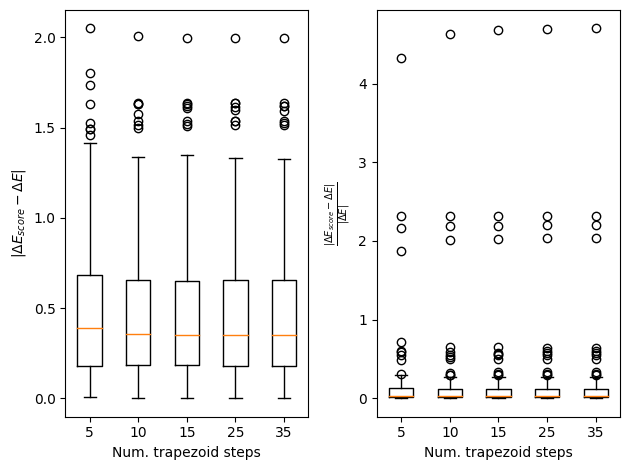

In [135]:
def compute_residuals(e_diff_est, e_diff_ref):
    # Extract values for all samples and various n_trapez
    diff_est = th.tensor([v for v in e_diff_est.values()])
    diff_ref = th.tensor([v for v in e_diff_ref.values()]).unsqueeze(dim=1)
    residual = (diff_est - diff_ref).abs()
    relative_residual = residual / energies.abs()
    return residual, relative_residual

res, rel_res = compute_residuals(eds, energy)
fig, (ax_box, ax_box_rel) = plt.subplots(1, 2)
ax_box.boxplot(res.T, labels=ns);
ax_box.set_xlabel("Num. trapezoid steps")
ax_box.set_ylabel("$|\Delta E_{score} - \Delta E$|")

ax_box_rel.boxplot(rel_res.T, labels=ns);
ax_box_rel.set_xlabel("Num. trapezoid steps")
ax_box_rel.set_ylabel("$\\frac{|\Delta E_{score} - \Delta E|}{|\Delta E|}$")
fig.tight_layout()


## Reference residuals for integration of EBM vs. $\Delta E$
Here we look at the residuals when estimating the energy from the energy parameterisation in two ways:
- $\Delta E = E_\theta(\hat{x}_t) - E_\theta(x_t)$, i.e. actually evaluating the energy at the two points.
- Estimate $\Delta E_{EBM} = \int \nabla E_\theta \cdot r'(s)\, d s$, by integrating the gradient of the energy parameterised model.
  The integral is approximated with the (equidistant) trapezoid method on a straight line between $x_t$ and $\hat{x}_t$, for varying resolutions (number of trapz steps $n$)

It is clear that the trapezoid estimate will converge to $\Delta E$ as $n \to \infty$, since we here actually have a conservative field
(the gradient $\nabla E_\theta$ is the actual gradient of the scalar energy function as opposed to the unconstrained vector field $\epsilon_\theta$).


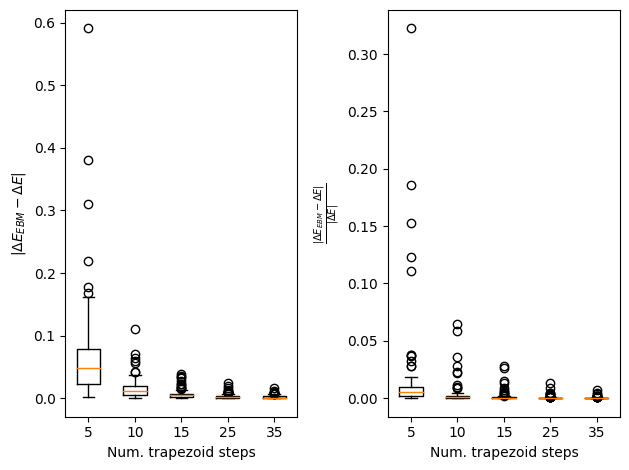

In [137]:
res, rel_res = compute_residuals(ede, energy)

fig, (ax_box, ax_box_rel) = plt.subplots(1, 2)
ax_box.boxplot(res.T, labels=ns);
ax_box.set_xlabel("Num. trapezoid steps")
ax_box.set_ylabel("$|\Delta E_{EBM} - \Delta E$|")

ax_box_rel.boxplot(rel_res.T, labels=ns);
ax_box_rel.set_xlabel("Num. trapezoid steps")
ax_box_rel.set_ylabel("$\\frac{|\Delta E_{EBM} - \Delta E|}{|\Delta E|}$")
fig.tight_layout()

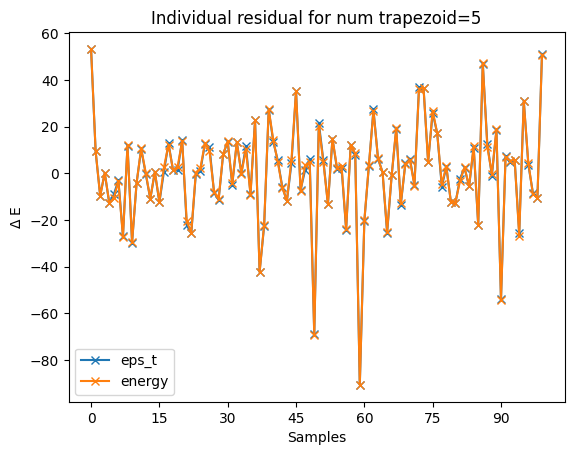

In [132]:
ax = plt.figure().gca()
tz_ind = 0
plt.plot([v[tz_ind] for v in eds.values()], 'x-', label='eps_t')
# plt.plot([v[tz_ind] for v in ede.values()], 'x-', label='E_t')
plt.plot([v for v in energy.values()], 'x-', label='energy')
plt.ylabel(r'$\Delta$ E')
plt.xlabel('Samples')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
ax.set_title(f"Individual residual for num trapezoid={ns[tz_ind]}");

## Energy Compare (2 samples at same t-X and t)

In [124]:
data_iter = iter(dataloader_train)
N = 20
X = 50
ts_save = []
eds, ede, energy = {}, {}, {}
for i in tqdm(range(N)):
    data = next(data_iter)
    x0 = data['pixel_values'].to(device)
    y = data['label'].to(device)
    t = th.randint(X, num_diff_steps, (1,)).item()
    t_hat = t - X
    
    noise = th.randn_like(x0)
    ts_hat = th.ones((1,), device=device).long() * t_hat
    x_t_hat = diff_sampler.q_sample(x_0=x0, ts=ts_hat, noise=noise)
    noise = th.randn_like(x0)
    ts = th.ones((1,), device=device).long() * t
    x_t = diff_sampler.q_sample(x_0=x0, ts=ts, noise=noise)
    
    energy_diff = guid_sampler_energy.energy(x_t, t_hat, None, y) - guid_sampler_energy.energy(x_t_hat, t_hat, None, y)
    energy[i] = energy_diff.detach().cpu().item()
    ns = [20]
    eds_, ede_ = [], []
    for n in ns:
        ss = th.linspace(0, 1, steps=n).to(device)
        x_t_hat = x_t_hat.requires_grad_(True)
        x_t = x_t.requires_grad_(True)
        energy_diff_estimate = estimate_energy_diff_linear(guid_sampler_energy.grad_energy, x_t_hat, x_t, t_hat, t_hat, ss, y, x0.dim())
        energy_diff_estimate_score = estimate_energy_diff_linear(guid_sampler_score.grad_energy, x_t_hat, x_t, t_hat, t_hat, ss, y, x0.dim())
        ede_.append(energy_diff_estimate.detach().cpu().item())
        eds_.append(energy_diff_estimate_score.detach().cpu().item())
    eds[i] = eds_
    ede[i] = ede_

100%|███████████████████████████████████████████████| 20/20 [00:41<00:00,  2.10s/it]


In [116]:
t_hat

696

In [117]:
t

746

In [118]:
guid_sampler_energy.energy(x_t_hat, t_hat, None, y)

tensor([358.3796], device='cuda:0', grad_fn=<AddBackward0>)

In [119]:
guid_sampler_energy.energy(x_t, t_hat, None, y)

tensor([357.1029], device='cuda:0', grad_fn=<AddBackward0>)

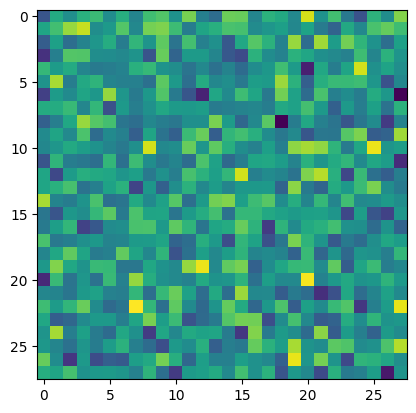

In [120]:
plt.imshow(x_t_hat.detach().cpu().squeeze())

In [141]:
[guid_sampler_energy.energy(x_t_hat, i, None, y).cpu().item() for i in np.arange(0, 1000, 10)]

[705.9931030273438,
 792.1541748046875,
 826.6652221679688,
 844.4664916992188,
 853.5360717773438,
 853.759033203125,
 854.0206909179688,
 848.3506469726562,
 842.353271484375,
 832.5469360351562,
 821.764404296875,
 814.9979248046875,
 802.3052978515625,
 785.1423950195312,
 770.7791748046875,
 758.2421875,
 752.85107421875,
 736.9614868164062,
 724.009033203125,
 707.9562377929688,
 692.7266845703125,
 680.5545043945312,
 667.7462768554688,
 652.2406616210938,
 640.81494140625,
 627.0059204101562,
 615.7564086914062,
 599.4053344726562,
 587.1519165039062,
 571.7796020507812,
 561.0091552734375,
 553.18994140625,
 539.5200805664062,
 531.4169311523438,
 522.22900390625,
 509.4651184082031,
 500.15753173828125,
 488.5003662109375,
 479.30316162109375,
 473.1480712890625,
 461.3736267089844,
 453.8928527832031,
 447.5557556152344,
 439.23004150390625,
 434.04876708984375,
 426.3462219238281,
 419.4873046875,
 413.0932922363281,
 405.7672424316406,
 401.1953125,
 394.14776611328125,
 3

In [121]:
print('Percentage of positive energi difference: ', np.sum(np.array(list(energy.values())) > 0)/N)

Percentage of positive energi difference:  0.0
